# Exercise to "The Neural Basis of Episodic Memory" from the GRK Lecture Series

Youssef Kashef

In [4]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
import matplotlib.pyplot as plt
%matplotlib inline

def nearest_neighbors_sorted(x, y):
    """ Locate timestamp pairs """
    x, y = map(np.asarray, (x, y))
    y_idx = np.argsort(y)
    y = y[y_idx]
    nearest_neighbor = np.empty((len(x),), dtype=np.intp)
    for j, xj in enumerate(x) :
        idx = np.searchsorted(y, xj)
        if idx == len(y) or idx != 0 and y[idx] - xj > xj - y[idx-1] :
            idx -= 1
        nearest_neighbor[j] = y_idx[idx]
        y = np.delete(y, idx)
        y_idx = np.delete(y_idx, idx)
    return nearest_neighbor

## 1. Phase Precession

Load data and initialize variables

In [5]:
fpath = '/home/kashefy/phd/grk_lecture_series/08_kempter/data.mat'

dat = loadmat(fpath)
print dat.keys()
lfp = dat['lfp']
lfp_t = dat['lfp_t']
pos_x = dat['pos_x']
pos_y = dat['pos_y']
pos_t = dat['pos_t']
spk_t = dat['spk_t']

['pos_x', 'pos_y', 'lfp_t', '__header__', 'pos_t', '__globals__', 'lfp', '__version__', 'spk_t']


### a) Plot Trajectory

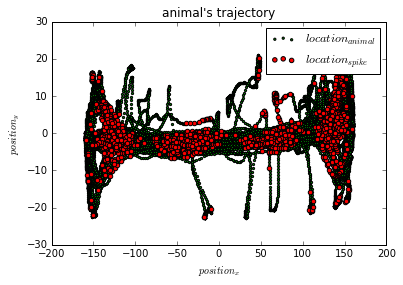

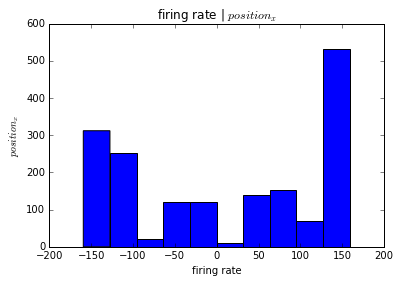

In [6]:
plt.figure()
plt.scatter(pos_x, pos_y,
            s=20, c='g', marker='.', label=r'$location_{animal}$')
spk_t_idx = nearest_neighbors_sorted(spk_t.ravel(), pos_t.ravel())
plt.scatter(pos_x[spk_t_idx], pos_y[spk_t_idx],
            s=80, c='r', marker='.', label=r'$location_{spike}$')
plt.title("animal's trajectory")
plt.xlabel(r'$position_{x}$')
plt.ylabel(r'$position_{y}$')
plt.legend()

plt.figure()
plt.hist(pos_x[spk_t_idx])
plt.title(r'firing rate | $position_{x}$')
plt.xlabel('firing rate')
plt.ylabel(r'$position_{x}$')

### b) estimate spike phases

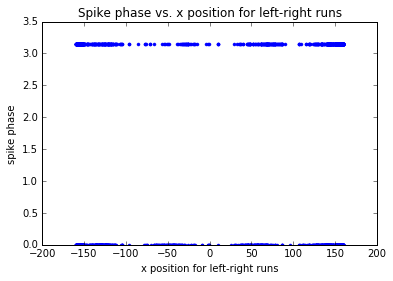

In [8]:
dx_lr_idx, _ = np.where(np.diff(pos_x, axis=0) > 0) # positive speeds, from left to right
pos_t_lr = pos_t[dx_lr_idx]
spk_t_lr_idx = nearest_neighbors_sorted(spk_t.ravel(), pos_t_lr.ravel())

spk_t_lr = pos_t_lr[spk_t_lr_idx]
lfp_t_idx = nearest_neighbors_sorted(spk_t_lr.ravel(), lfp_t.ravel())

pos_x_lr = pos_x[dx_lr_idx]
phase = np.angle(hilbert(lfp))
plt.plot(pos_x_lr[spk_t_lr_idx], phase[lfp_t_idx], '.')
plt.title(r'Spike phase vs. x position for left-right runs')
plt.xlabel('x position for left-right runs')
plt.ylabel('spike phase')

## Grid-cell Pattern Formation

### a) Distribute input centers

In [9]:
N = 900
L = 4.0 # [m]
a = 1.0
A_pos = 10.1
A_neg = 10.0
sigma_pos = 0.295 # [m]
sigma_neg = 0.3 # [m]
tau = 2.0 # [sec]
B = 0.3
dt = 0.050 # [sec]
T = 200 # [sec]

x, y = np.mgrid[-L/2:L/2:L/np.sqrt(N),-L/2:L/2:L/np.sqrt(N)]
centers = np.array([x.ravel(), y.ravel()]).T

### b) Compute Correlation Matrix

In [11]:
def pdist(x1, x2, y1, y2, L):
    
    dx = np.abs(x1-x2)
    x_p = min(dx, L-dx)
    dy = np.abs(y1-y2)
    y_p = min(dy, L-dy)
    return np.sqrt(x_p*x_p + y_p*y_p)

c = np.empty([N, N])
for i in xrange(N):
    for j in xrange(N):
        d_ij = pdist(x.ravel()[i], x.ravel()[j], y.ravel()[i], y.ravel()[j], L)
        d_ij_sq = d_ij*d_ij
        c[i, j] = A_pos * np.exp(-d_ij_sq/(2. * sigma_pos * sigma_pos)) - A_neg * np.exp(-d_ij_sq / (2. * sigma_neg * sigma_neg))

### c) Simulate Weight Dynamic

In [18]:
w_avg = B/(a-np.sum(c)/N)
w = np.random.rand(N) * 2. * w_avg
time_ = np.arange(0, T, dt)
t_plot = np.linspace(0, T, num=7) # time steps at which to plot weight vector

t_plot_idx = 1
for t in time_:
    w_t = np.copy(w)
    for i in xrange(N):
        w[i] = w_t[i] + dt/tau * (-a*w_t[i] + np.sum(c[i] * w_t + B))
    w = np.abs(w)

    if t == t_plot[t_plot_idx-1]:
        plt.subplot(1, len(t_plot), t_plot_idx)
        t_plot_idx += 1
        plt.imshow(np.reshape(w, (int(np.sqrt(N)), int(np.sqrt(N)))))
        plt.title('at t=%f' % (t,))
plt.suptitle('Evolution of weight vector')

SyntaxError: invalid syntax (<ipython-input-18-4aefd9d1c73e>, line 17)

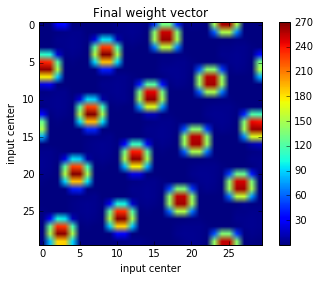

In [14]:
plt.imshow(np.reshape(w, (int(np.sqrt(N)), int(np.sqrt(N)))))
plt.title('Final weight vector')
plt.xlabel("input center")
plt.ylabel("input center")
plt.colorbar()